# Option Pricing with Quantum Amplitude Estimation (QAE)

> Contact : Ziyuan Li (stan.ziyuan.li@hsbc.com.cn) 

## 1. Introduction
Option pricing rests on Monte Carlo sampling which can achieve a quadratic speed up by replacing the classical Monte Carlo sampling approach with a quantum algorithm that leverages quantum effects to compute things faster.

## 2. Option Pricing with Monte Carlo Methods

Monte Carlo methods are used to develop a price distribution for the underlying asset. If we have a price distribution of the underlying asset, then we can begin to get a sense of what the fair price for the option should be.

Using a convenient result called Itô's lemma, we can then derive the formula for the share price at time T as 

$$S_T = S_0e^{(r-\frac{1}{2}\sigma^2)T + \sigma W_T}$$

where $S_0$ is the share price today, $r$ is average return of the underlying, $\sigma$ is volatility of the underlying, $W_T$ follows the normal distribution with mean 0 and variance $T$.

Now we can code up this function and use lots of random values to evaluate it.

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Monte Carlo valuation of a European call option 

# set a random seed to reproduce our results
np.random.seed(20220125)

# set the parameters
S0 = 50 # initial price of the underlying asset
K = 55 # strike price
r = 0.05 # average return of the underlying
sigma = 0.4 # volatility of the underlying
T = 1 # time till execution
t = 30 # number of time steps we want to divide T in
dt = T / t # incremental time step size
M = 10000 # number of paths to simulate

# Simulating M price paths with t time steps
# sum instead of cumsum would also do if only the final values at end of the month (i.e. at time T) are of interest
S = S0 * np.exp(np.cumsum((r - 0.5 * sigma ** 2) * dt + sigma * math.sqrt(dt)* np.random.standard_normal((t + 1, M)), axis=0))

# Calculating the Monte Carlo estimator for the expected payoff
P_call = sum(np.maximum(S[-1] - K, 0)) / M

# Results output
print("The call option value is:  {:0.2f}$ .\n".format(P_call))

The call option value is:  7.59$ .



Let's visualise the multiple paths that the underlying share price could take. The resulting call option value is calculated using an average of these paths.

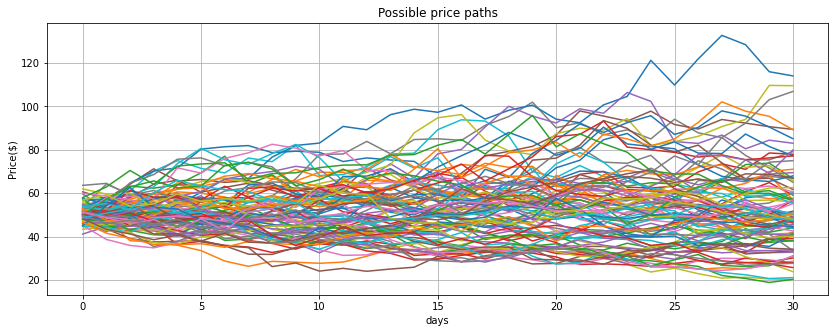

In [2]:
num_paths_to_plot = 100
plt.figure(figsize= (14,5))
plt.plot(S[:, :num_paths_to_plot])
plt.grid(True)
plt.xlabel('days')
plt.ylabel('Price($)')
plt.title('Possible price paths')
plt.show()

Let’s investigate the frequency of the simulated index levels at the end of the simulation period

Text(0, 0.5, 'frequency')

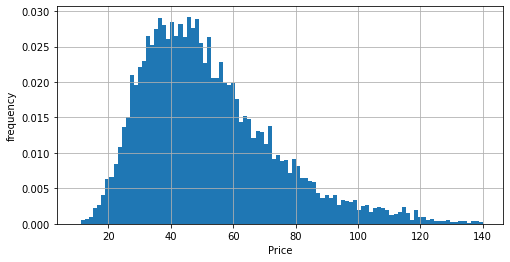

In [3]:
plt.figure(figsize= (8,4))
weights = np.ones_like(S[-1]) / len(S[-1])
plt.hist(S[-1], range=(10, 140), bins=100, weights=weights)
#plt.hist(S[-1], range=(10, 140), bins=100, density=1)
plt.grid(True)
plt.xlabel('Price')
plt.ylabel('frequency')

Let’s look at the histogram of all simulated end-of-period option values

Text(0, 0.5, 'frequency')

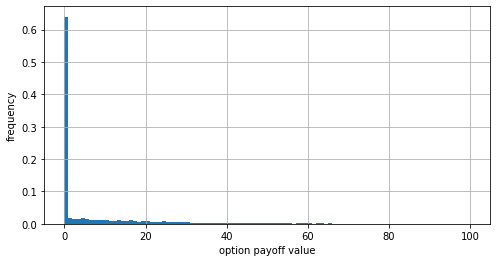

In [4]:
plt.figure(figsize= (8,4))
#plt.hist(np.maximum(S[-1] - K, 0), bins=10, range=(0,200), density=1)
plt.hist(np.maximum(S[-1] - K, 0), weights=weights, bins=100, range=(0,100))
#plt.hist(np.maximum(S[-1] - K, 0),  density=1)
plt.grid(True)
plt.xlabel('option payoff value')
plt.ylabel('frequency')

## 3. Option Pricing with QAE

Quantum Amplitude Estimation, which can estimate a parameter's value with a convergence rate in the order of $\mathcal{O}(M^{-1})$, where $M$ is the number of samples required. This represents a theoretical quadratic speed-up compared to Monte Carlo methods that run on classical computers with a convergence rate of $\mathcal{O}(M^{-1/2})$. 

<img src="images/qcalg_speedup.png" alt="fishy" class="bg-primary" width="500px">


In [5]:
#First we import all the required libraries
from qiskit import Aer, QuantumCircuit
from qiskit.utils import QuantumInstance
from qiskit.compiler import transpile
from qiskit.algorithms import IterativeAmplitudeEstimation, EstimationProblem
from qiskit.circuit.library import LinearAmplitudeFunction
from qiskit_finance.circuit.library import LogNormalDistribution, EuropeanCallPricingObjective

## Basic Procedure
Step 1. Represent the probability distribution P describing the evolution of random variables $X=\{X_1, X_2, ..., X_N\}$ on the quantum computer;
<br>
Step 2. Construct the circuit which computes the payoff $f(X)$;
<br>
Step 3. Calculate the expectation value of the payoff $\mathbb{E}_P[f(X)]$.

### Step 1. Load variables distribution with Uncertainty Model

Circuit that takes a probability distribution implied for possible asset prices in the future and loads it into a quantum register such that each basis state represents a possible value and its amplitude the corresponding probability. The distribution loading module creates the state:
<br>
$$|\psi\rangle_{n} = \sum_{i=0}^{2^n-1} \sqrt{p_i} |S_{i}\rangle_{n}$$
<h3><center>Example price distribution at maturity loaded in a three-qubit register</center></h3>
<img src="images/qcalg_encodeprice.png" alt="fishy" class="bg-primary" width="500px">


In [6]:
# number of qubits to represent the uncertainty/distribution
num_uncertainty_qubits = 3

# parameters for considered random distribution
S = 50       # initial spot price
strike_price = 55
vol = 0.4     # volatility of 40%
r = 0.05      # annual interest rate of 5%
T = 30 / 365  # 30 days to maturity

# resulting parameters for log-normal distribution
mu = ((r - 0.5 * vol**2) * T + np.log(S))
sigma = vol * np.sqrt(T)
mean = np.exp(mu + sigma**2/2)
variance = (np.exp(sigma**2) - 1) * np.exp(2*mu + sigma**2)
stddev = np.sqrt(variance)

# lowest and highest value considered for the spot price; in between, an equidistant discretization is considered.
# we truncate the distribution to the interval defined by 2 standard deviations around the mean
low  = np.maximum(0, mean - 2*stddev) 
high = mean + 2*stddev

# construct circuit factory for uncertainty model
uncertainty_model = LogNormalDistribution(num_uncertainty_qubits, mu=mu, sigma=sigma**2, bounds=(low, high))

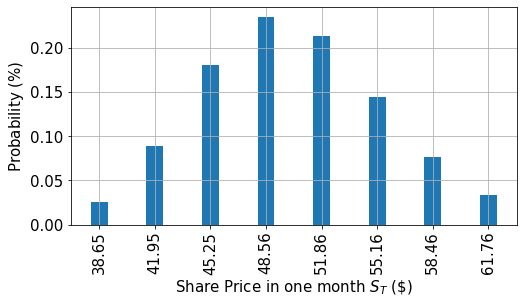

In [7]:
# plot probability distribution
x = uncertainty_model.values
y = uncertainty_model.probabilities
plt.figure(figsize= (8,4))
plt.bar(x, y, width=1)
plt.xticks(x, size=15, rotation=90)
plt.yticks(size=15)
plt.grid()
plt.xlabel('Share Price in one month $S_T$ (\$)', size=15)
plt.ylabel('Probability ($\%$)', size=15)
plt.show()

### Step 2. Load payoff fuction with LinearAmplitudeFunction
#### Payoff function

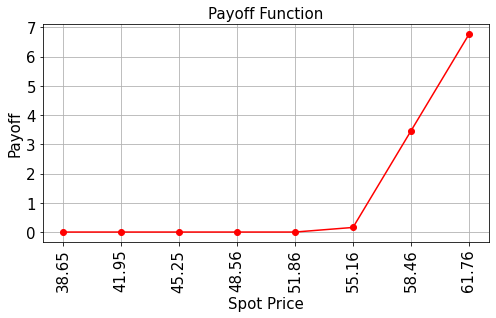

In [8]:
# plot exact payoff function (evaluated on the grid of the uncertainty model)
x = uncertainty_model.values
y = np.maximum(0, x - strike_price)
plt.figure(figsize= (8,4))
plt.plot(x, y, 'ro-')
plt.grid()
plt.title('Payoff Function', size=15)
plt.xlabel('Spot Price', size=15)
plt.ylabel('Payoff', size=15)
plt.xticks(x, size=15, rotation=90)
plt.yticks(size=15)
plt.show()

#### Linear function
Consider linear functions $f:\{0, ..., 2n−1\} \rightarrow [0, 1]$ which we write $f(i) = f_1i + f_0$. We can efficiently create an operator that performs
<br>
$$|i\rangle_{n}|0\rangle \rightarrow |i\rangle_{n} ( \cos[f(i)]|0\rangle + \sin[f(i)]|1\rangle)$$
using controlled Y-rotations

<h3><center>Quantum circuit to generate state for linear function in a three-qubit register. After applying this circuit the quantum state is $|i\rangle_{3}[\cos(f_1i+f_0)|0\rangle + \sin(f_1i+f_0)|1\rangle]$</center></h3>

<img src="images/qcalg_linearfun.png" alt="fishy" class="bg-primary" width="500px">

<div>
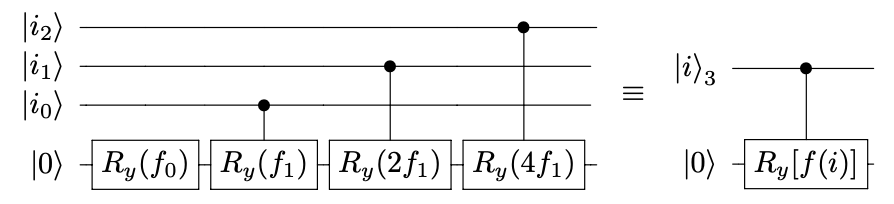
</div>

<br>
How to obtain $\mathbb{E}[f(X)]$ for a linear function $f$ of a random variable $X$ which is mapped to integer values $i \in \{0, ..., 2n − 1\}$ that occur with probability $p_i$ respectively? Using the procedure outlined above to create the operator that maps:
$$\sum_{i}^{2^n-1} \sqrt{p_{i}} |i\rangle_{n}|0\rangle \rightarrow 
\sum_{i}^{2^n-1} \sqrt{p_{i}} |i\rangle_{n} ( \cos[c\tilde{f}(i) + \frac{\pi}{4}]|0\rangle + \sin[c\tilde{f}(i) + \frac{\pi}{4}]|1\rangle)$$
where $c \in [0, 1]$ is an scailing parameter, and $\tilde{f}(i)$ is a scaled version of $f(i)$ given by
$$\tilde{f}(i) = 2 \frac{f(i)-f_{min}}{f_{max}-f_{min}} - 1$$
so that $\tilde{f}(i) \in [-1, 1]$. We exploit the fact that $\sin^2(y + \pi/4) \approx y + 1/2$ for small $|y|$. Thus, the probability to find the ancilla qubit in state $|1\rangle$ is well approximated by
$$P_{1} = \sum_{i}^{2^n-1} p_i \sin^2(c\tilde{f}(i) + \frac{\pi}{4})
\approx \sum_{i}^{2^n-1} p_i (c\tilde{f}(i) + \frac{1}{2})
= (\frac{1}{2} - c) + 2c \frac{\mathbb{E}[f(X)]-f_{min}}{f_{max}-f_{min}}$$
Because we know the values of $f_{min}$, $f_{max}$ and $c$, we can recover $\mathbb{E}[f(X)]$ since QAE allows us to efficiently retrieve $P_1$ 


#### Comparator
<h3><center>Quantum circuit to set ancilla qubit $|c\rangle$ to state $|1\rangle$ if $i>K$ ($K$ means strike price)</center></h3>
<img src="images/qcalg_comparator.png" alt="fishy" class="bg-primary" width="500px">

#### Piecewise Linear function
For piece-wise payoff function $f(i)=max(0,i-K)$, the final stae of n+2 qubits is
$$ \sum_{i < K} \sqrt{p_{i}} |i\rangle_{n} |0\rangle ( \cos(g_0) |0\rangle + \sin(g_0) |1\rangle )
+ \sum_{i \ge K} \sqrt{p_{i}} |i\rangle_{n} |1\rangle ( \cos(g_0 + g(i)) |0\rangle + \sin(g_0 + g(i)) |1\rangle )
$$
The probability to find the second ancilla in state $|1\rangle$ is
$$
P_1 = \sum_{i < K} p_{i} \sin^2(g_0) + \sum_{i\ge K} p_{i} \sin^2(g_0 + g(i))
$$
where $g_0 = \frac{\pi}{4} - c$ and $g(i) = \frac{2c(i-K)}{i_{max}-K}$. Using $\sin^2(y + \pi/4) \approx y + 1/2$ leads to
$$
P_1 \approx \sum_{i < K} p_{i} (\frac{1}{2} - c) + \sum_{i\ge K} p_{i} (\frac{2c(i-K)}{i_{max}-K} + \frac{1}{2} - c)
= \frac{1}{2} - c + \frac{2c}{i_{max}-K} \sum_{i\ge K} p_{i} (i - K)
= \frac{1}{2} - c + \frac{2c}{i_{max}-K} \mathbb{E}[f(i)]
$$
Because we know the values of $i_{max}$, $K$ and $c$, we can recover $\mathbb{E}[f(i)]$ since QAE allows us to efficiently retrieve $P_1$ 

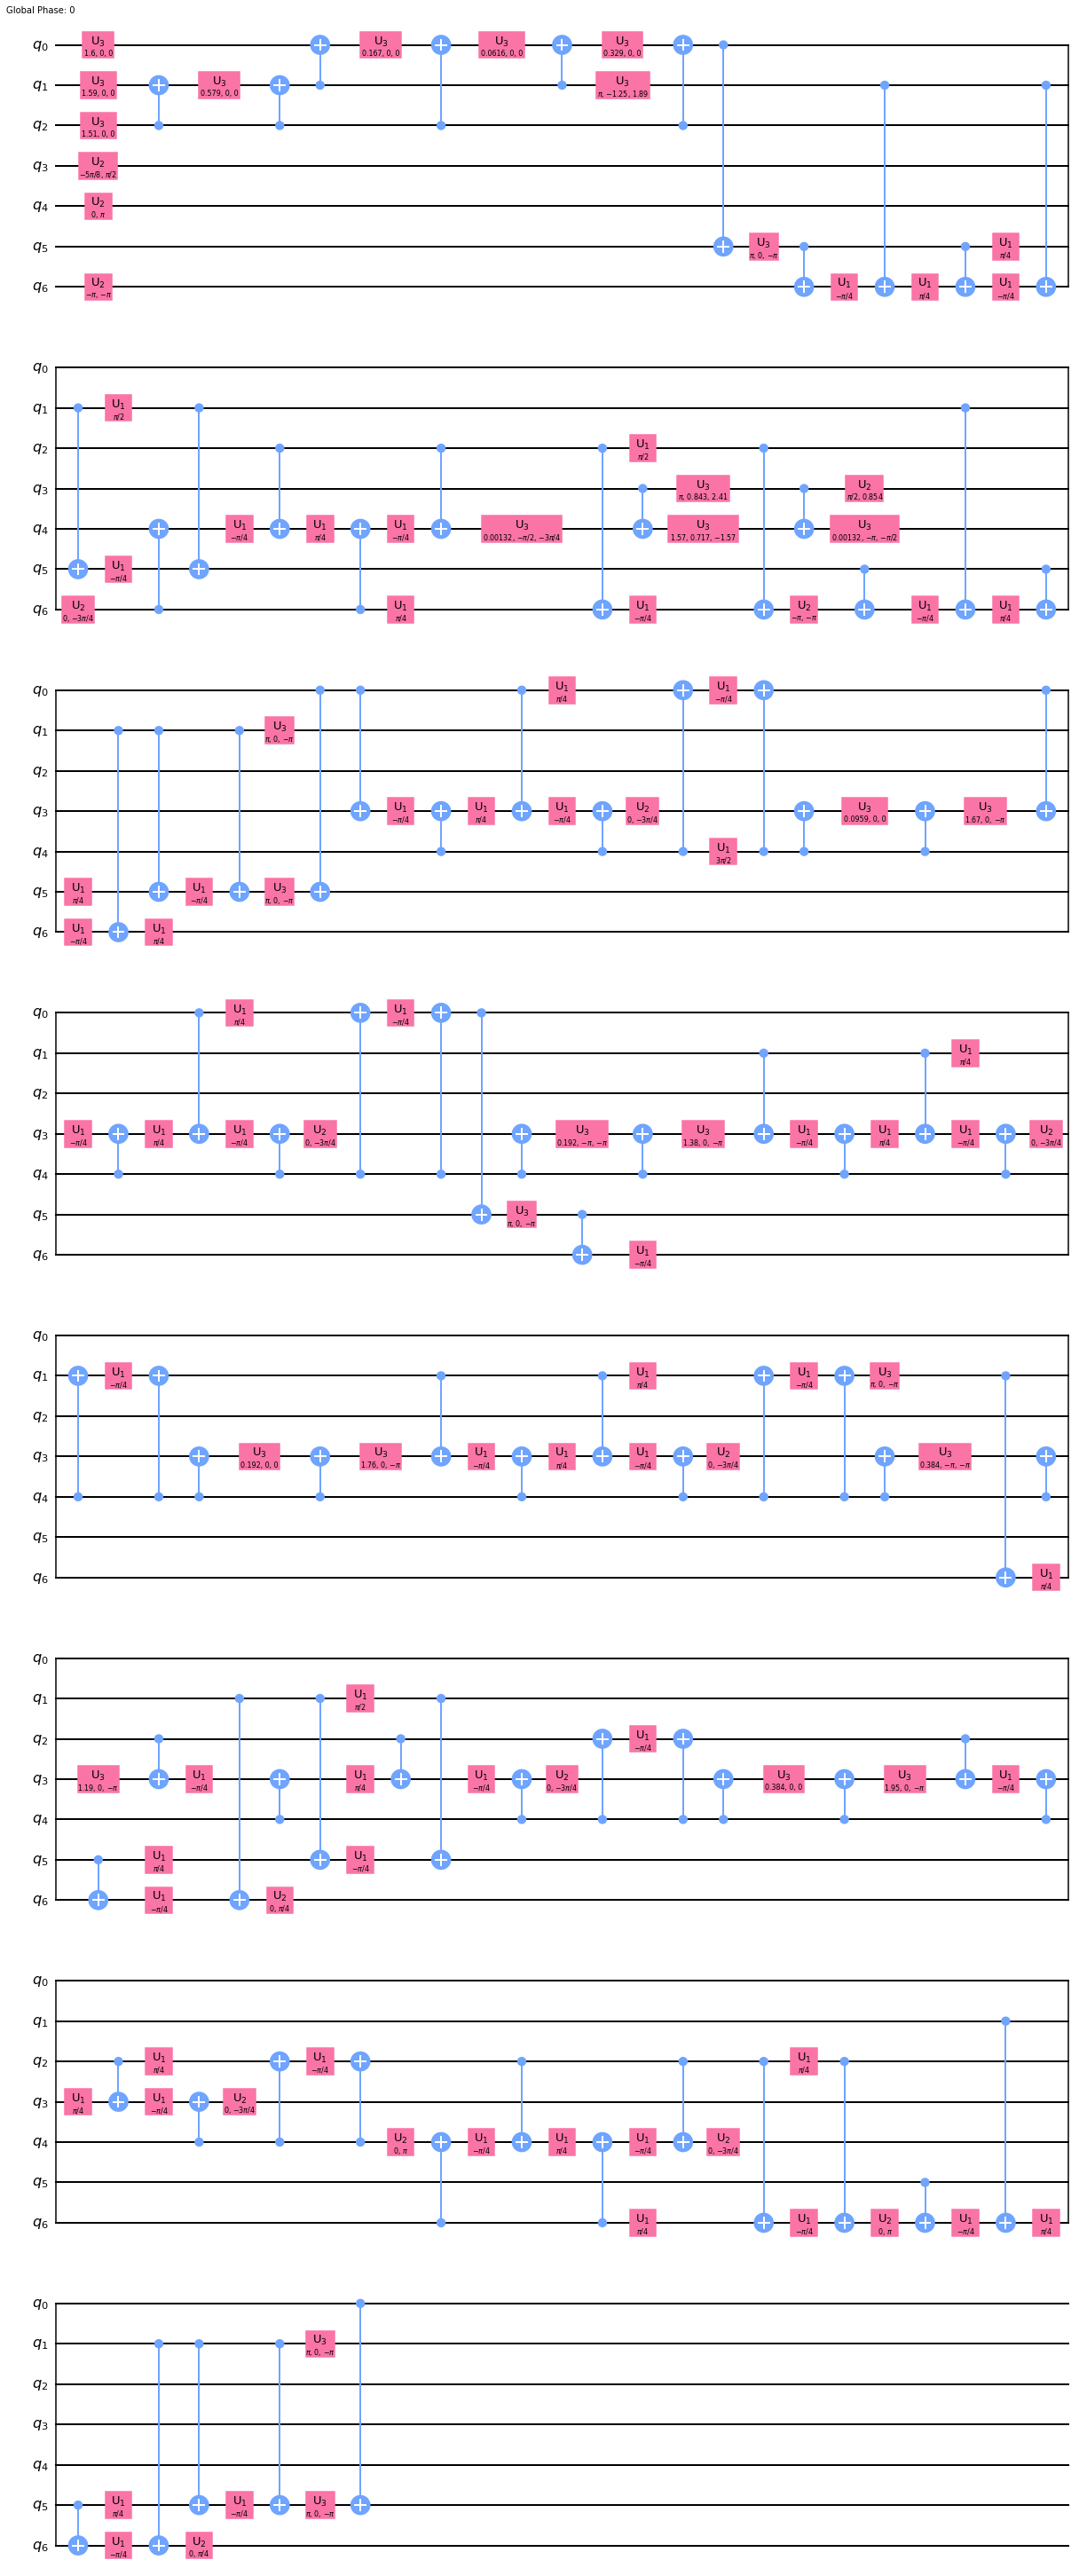

In [9]:
# set the approximation scaling for the payoff function
c_approx = 0.25

# setup piecewise linear objective fcuntion
breakpoints = [low, strike_price]
slopes = [0, 1]
offsets = [0, 0]
f_min = 0
f_max = high - strike_price
european_call_objective = LinearAmplitudeFunction(
    num_uncertainty_qubits,
    slopes,
    offsets,
    domain=(low, high),
    image=(f_min, f_max),
    breakpoints=breakpoints,
    rescaling_factor=c_approx,
)

# construct A operator for QAE for the payoff function by
# composing the uncertainty model and the objective
num_qubits = european_call_objective.num_qubits
european_call = QuantumCircuit(num_qubits)
european_call.append(uncertainty_model, range(num_uncertainty_qubits))
european_call.append(european_call_objective, range(num_qubits))

# draw the circuit
european_call.draw()

result = transpile(european_call, basis_gates=['u1', 'u2', 'u3', 'cx'], optimization_level=3)
result.draw(output='mpl')

### Step 3. Calculate expectation value of the payoff

In [10]:
# set target precision and confidence level
epsilon = 0.01
alpha = 0.05
shots = 100
simulator = 'qasm_simulator'
#simulator = 'aer_simulator'

qi = QuantumInstance(Aer.get_backend(simulator), shots=shots)
problem = EstimationProblem(
    state_preparation=european_call,
    objective_qubits=[num_uncertainty_qubits],
    post_processing=european_call_objective.post_processing,
)
# construct amplitude estimation
ae = IterativeAmplitudeEstimation(epsilon, alpha=alpha, quantum_instance=qi)
result = ae.estimate(problem)

In [11]:
# evaluate exact expected value (normalized to the [0, 1] interval)
exact_value = np.dot(uncertainty_model.probabilities, y)

conf_int = np.array(result.confidence_interval_processed)
print('Exact value:        \t%.4f' % exact_value)
print('Estimated value:    \t%.4f' % (result.estimation_processed))
print('Estimation error:   \t%.4f' % (np.abs(exact_value-result.estimation_processed)))
print('Confidence interval:\t[%.4f, %.4f]' % tuple(conf_int))

Exact value:        	0.5152
Estimated value:    	0.6089
Estimation error:   	0.0937
Confidence interval:	[0.5640, 0.6539]


### Evaluate Delta

The Delta is a bit simpler to evaluate than the expected payoff.
Similarly to the expected payoff, we use a comparator circuit and an ancilla qubit to identify the cases where $S_T > K$.
However, since we are only interested in the probability of this condition being true, we can directly use this ancilla qubit as the objective qubit in amplitude estimation without any further approximation.

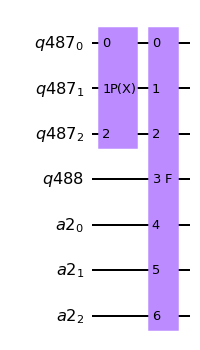

In [12]:
# setup a piecewise linear objective function
num_uncertainty_qubits = 3

# construct circuit factory for uncertainty model
uncertainty_model = LogNormalDistribution(num_uncertainty_qubits, mu=mu, sigma=sigma**2, bounds=(low, high))

european_call_delta_objective = LinearAmplitudeFunction(
    num_uncertainty_qubits,
    slopes,
    offsets,
    domain=(low, high),
    image=(f_min, f_max),
    breakpoints=breakpoints,
)

# construct circuits for payoff function
european_call_delta = european_call_delta_objective.compose(uncertainty_model, front=True)
european_call_delta.draw()

In [13]:
# Set up the estimation problem using qiskit 
problem = EstimationProblem(state_preparation=european_call_delta,
                            objective_qubits=[num_uncertainty_qubits],
                           )

# construct amplitude estimation
ae_delta = IterativeAmplitudeEstimation(epsilon, alpha=alpha, quantum_instance=qi)

# get the estimated result
result_delta = ae_delta.estimate(problem)

In [14]:
# compute the exact result
x = uncertainty_model.values
exact_delta = sum(uncertainty_model.probabilities[x >= strike_price])

# compare results
conf_int = np.array(result_delta.confidence_interval)[::-1]
print('Exact delta:    \t%.4f' % exact_delta)
print('Esimated value: \t%.4f' % result_delta.estimation_processed)
print('Estimation error:    \t%.4f' %(np.abs(exact_delta-result_delta.estimation)))
print('Confidence interval: \t[%.4f, %.4f]' % tuple(conf_int))

print("************ FIXME LATER : Someting wrong with this method ************")

Exact delta:    	0.2552
Esimated value: 	0.0737
Estimation error:    	0.1815
Confidence interval: 	[0.0754, 0.0720]
************ FIXME LATER : Someting wrong with this method ************


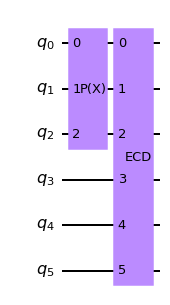

In [15]:
from qiskit_finance.applications.estimation import EuropeanCallDelta

european_call_delta = EuropeanCallDelta(
    num_state_qubits=num_uncertainty_qubits,
    strike_price=strike_price,
    bounds=(low, high),
    uncertainty_model=uncertainty_model,
)
european_call_delta_circ = QuantumCircuit(european_call_delta._objective.num_qubits)
european_call_delta_circ.append(uncertainty_model, range(num_uncertainty_qubits))
european_call_delta_circ.append(
    european_call_delta._objective, range(european_call_delta._objective.num_qubits)
)
european_call_delta_circ.draw()

In [16]:
# set target precision and confidence level
epsilon = 0.01
alpha = 0.05

qi = QuantumInstance(Aer.get_backend("aer_simulator"), shots=100)
problem = european_call_delta.to_estimation_problem()

# construct amplitude estimation
ae_delta = IterativeAmplitudeEstimation(epsilon, alpha=alpha, quantum_instance=qi)
result_delta = ae_delta.estimate(problem)
conf_int = np.array(result_delta.confidence_interval_processed)
print("Exact delta:    \t%.4f" % exact_delta)
print("Esimated value: \t%.4f" % european_call_delta.interpret(result_delta))
print("Confidence interval: \t[%.4f, %.4f]" % tuple(conf_int))

Exact delta:    	0.2552
Esimated value: 	0.2546
Confidence interval: 	[0.2498, 0.2594]


> Reference 
> 1. https://jsybruce.github.io/Homepage/2021/12/01/Option-Pricing-with-Quantum-Monte-Carlo-Simulation-copy.html
> 2. Stamatopoulos, Nikitas, et al., "Option pricing using quantum computers." Quantum 4 (2020): 291.
> 3. H.Tang, et al., "Quantum computation for pricing the collateralized debt obligations", Quantum Engineering (2021)
